In [1]:
import numpy as np
# import shtns
import pylab as py
import matplotlib
from tqdm import tqdm
import sys
from scipy.signal import savgol_filter

sys.path.append('/data/pbarpanda/python_scripts/modules/')
import logruns as logruns
import save_and_load_hdf5_files as h5saveload
import eulerian_fluxes as eflux
import netcdf_utilities as ncutil
import os
os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'
from tqdm import tqdm
import glob
from PIL import Image

import time as ti
import numpy.ma as ma
import math
import string

sys.path.append('/data/pbarpanda/python_scripts/modules/')
import logruns as logruns
import save_and_load_hdf5_files as h5saveload
import eulerian_fluxes as eflux
import netcdf_utilities as ncutil
from obspy.geodetics import kilometers2degrees
import momentum_advection_class as momentum_advect
from PIL import Image
import imageio
from IPython.display import Video
import scipy.special as special
from scipy import integrate
from IPython.display import Image
import matplotlib.ticker as ticker


from datetime import date
today = date.today()

# Month abbreviation, day and year	
today_date = today.strftime("%b-%d-%Y")
print("Today is =", today_date)
print("Have a nice day coding!")



# import cmasher as cmr
# cmap = cmr.rainforest                   # CMasher
# cmap = plt.get_cmap('cmr.rainforest')   # MPL

import matplotlib as mpl
from cycler import cycler

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.edgecolor'] = 'black'
mpl.rcParams['figure.dpi']       = 100
mpl.rcParams['axes.facecolor']   = 'white'
mpl.rcParams['axes.edgecolor']   = 'black'
mpl.rcParams['xtick.color']      = 'black'
mpl.rcParams['ytick.color']      = 'black'
mpl.rcParams['lines.color']      = 'black'

import os
os.environ["HDF5_USE_FILE_LOCKING"] = 'FALSE'  ### This is because NOAA PSL lab computers are somehow not able to use 

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", 
      [  "darkred", "darkorange", "pink", "white", "white","skyblue", "dodgerblue", "navy"][::-1])

def colorbar(fontsize=20):
    cbar = py.colorbar()
    for t in cbar.ax.get_yticklabels():
         t.set_fontsize(fontsize)
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize)
    
def colorbar2(fontsize=20, im=None, AX=None, fig=py, ):
    if im is None:
        cbar = fig.colorbar()
    else:
        cbar = fig.colorbar(im, ax=AX)
    for t in cbar.ax.get_yticklabels():
         t.set_fontsize(fontsize)
    cbar.ax.yaxis.get_offset_text().set_fontsize(fontsize)

            
import warnings
warnings.filterwarnings('ignore')

import os
import glob

def remove_files(direc):
    files = glob.glob(direc, recursive=True)

    for f in files:
        try:
            os.remove(f)
        except OSError as e:
            print("Error: %s : %s" % (f, e.strerror))
            
def fmt(x, pos):
    a, b = ('%1.2e'%(x)).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)
fmt1 = ticker.FuncFormatter(fmt)


Today is = Jul-29-2022
Have a nice day coding!


In [15]:
bnd2 = 40

def locate(Y, x, gap=None):
    if gap is None:
        gap = 0.5*np.abs(np.diff(Y))[0] 
    index = np.where(np.abs(Y-x) <= gap)[0][0]
    return index

def eddy(X):
    return X-X.mean(axis=-1)[...,None]

def zmean(X):
    return X.mean(axis=-1)[...,None]

def t_eddy(X):
    return X-X.mean(axis=0)[None,...]

def locate(Y, x, gap=0.1):
    index = np.where(np.abs(Y-x) < gap)[0][0]
    return index

def locate(Y, x, gap=None):
    if gap is None:
        gap = 0.5*np.abs(np.diff(Y))[0] 
    index = np.where(np.abs(Y-x) <= gap)[0][0]
    return index


def tropical(field, bnd1=0, bnd2=20, sign=1):
    field = ma.masked_where(   ((( np.abs(latt) < bnd1)  | ( np.abs(latt) > bnd2))   |   (sign*field < 0) ), field)
    return field.filled(np.nan)

##subtropics
def subtropical(field,  bnd1=20, bnd2=40, sign=1):
    field = ma.masked_where(    ((( np.abs(latt) < bnd1)  | ( np.abs(latt) > bnd2))  |   (sign*field < 0) ) , field)
    return field.filled(np.nan)

def extratropical(field,  bnd1=40, bnd2=80, sign = 1):
    field = ma.masked_where(    ((( np.abs(latt) < bnd1)  | ( np.abs(latt) > bnd2)) |   (sign*field < 0) ), field)
    return field.filled(np.nan)

def forcing_region(field, forcing, sign = 1, scale=4):
    
    max_phi = np.max(forcing)/scale
    field   = ma.masked_where( sign*forcing < max_phi, field)
    return field.filled(np.nan)

def return_max_div_location(field, bnd1=0, bnd2=20, sign = 1):
    
    trop_field        = tropical(field, bnd1=bnd1, bnd2=bnd2, sign=sign)
    max_trop_field    = np.nanmax(trop_field*sign)
    index             = np.where(trop_field*sign == max_trop_field)
    la_pos, lo_pos = latt[index], lonn[index]
    return la_pos, lo_pos

def d_by_dx(lat, lon, field, logging_object=None):
    if logging_object is None:
        logging_object = logruns.default_log(logfilename   = 'momentum',  log_directory = './logs/')
    obj_momentum       = momentum_advect.momentum_advection(field, field, lat, lon, logging_object)            
    dudx  = obj_momentum.spher_div_x(field, lat,  lon, ax=-1)
    return np.squeeze(dudx)

def d_by_dy(lat, lon, field, logging_object=None):
    if logging_object is None:
        logging_object = logruns.default_log(logfilename   = 'momentum',  log_directory = './logs/')
    obj_momentum       = momentum_advect.momentum_advection(field, field, lat, lon, logging_object)            
    dvdy  = obj_momentum.spher_div_y(field, lat,  lon, ax=-2)
    return np.squeeze(dvdy)

def tropical_mask(lat, lon, field, bnd1=0, bnd2=bnd2):    
    lonn, latt = np.meshgrid(lon, lat)
    field = ma.masked_where(   ((( np.abs(latt) < bnd1)  | ( np.abs(latt) > bnd2))   ), field)
    return field.filled(np.nan)

def tropical_mask_outside(lat, lon,  field, bnd1=0, bnd2=bnd2):
    lonn, latt = np.meshgrid(lon, lat)
    field = ma.masked_where(   ((( np.abs(latt) > bnd1)  & ( np.abs(latt) < bnd2))   ), field)
    return field.filled(np.nan)

def Lrange(Y, dy=10):
    mini = np.abs(np.min(Y))
    maxi = np.abs(np.max(Y))
#     maxi = np.round((np.max([(mini), (maxi)])), 0)
    maxi = np.ceil((np.max([(mini), (maxi)])))
    range_values = np.linspace(-maxi, maxi, dy)
    return range_values

def div_func(lat, lon, u, v):
    dvdy = d_by_dy(lat, lon, v, logging_object=None)
    dudx = d_by_dx(lat, lon, u, logging_object=None)
    return dudx + dvdy

# def Lrange(Y, dy=10):
#     mini = np.abs(np.min(Y))
#     maxi = np.abs(np.max(Y))
#     maxi = np.ceil((np.max([(mini), (maxi)])))
#     range_values = np.linspace(-maxi, maxi, dy)
#     return range_values


In [77]:
!ls /data/pbarpanda/spherical_SWE/evaluate_final_budget/momentum_forcing/Hmean_500_forcing_phase_speed_5_ms/vortcity_forcing_midlat_loc_40_transient_Umax/


H0_5500


In [66]:
source = '/data/pbarpanda/spherical_SWE/evaluate_final_budget/momentum_forcing/Hmean_500_forcing_phase_speed_5_ms/vortcity_forcing_midlat_loc_40_transient_Umax/H0_5500/spatial_data.hdf5'

In [90]:
ls /data/pbarpanda/spherical_SWE/evaluate_final_budget/momentum_forcing_Aug_2022/vortcity_forcing_midlat_loc_40_transient_Umax/H0_5500/

input_file.hdf5  spatial_data.hdf5


In [97]:
ls /data/pbarpanda/spherical_SWE/evaluate_final_budget/transient_U_propagate_forcing_diff_Heq/dt_150_Q_forcing_10_forcing_y_0_Hmean_500_forcing_phase_speed_0_ms/U_up_days_217/H0_5000/

input_file.hdf5  post_process/  spatial_data.hdf5  velocity_decomp.hdf5


In [89]:
cp /data/pbarpanda/spherical_SWE/evaluate_final_budget/momentum_forcing/Hmean_500_forcing_phase_speed_5_ms/vortcity_forcing_midlat_loc_40_transient_Umax/H0_5500/* /data/pbarpanda/spherical_SWE/evaluate_final_budget/momentum_forcing_Aug_2022/vortcity_forcing_midlat_loc_40_transient_Umax/H0_5500/

In [67]:
temp = h5saveload.load_dict_from_hdf5(source)

In [69]:
temp.keys()

dict_keys(['PHI', 'T_in_days', 'U', 'V', 'abort_status', 'div', 'div_forcing', 'lats', 'lons', 'phi_B', 'phi_T', 'phi_forcing', 'vrt', 'vrt_forcing'])

In [70]:
temp['T_in_days'].shape

(4752,)

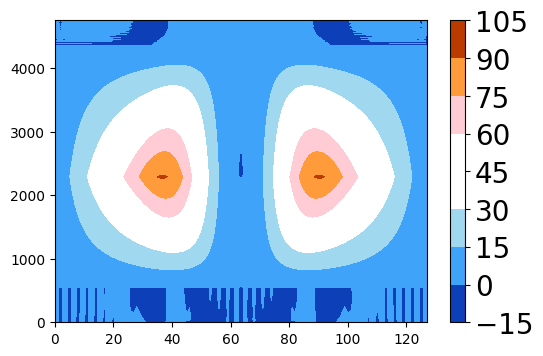

In [71]:
py.contourf(temp['U'].mean(axis=-1), cmap=cmap); colorbar(20)

In [59]:
# py.contourf((temp['vrt_forcing'][-1,...]).mean(axis=-1)); colorbar(20)

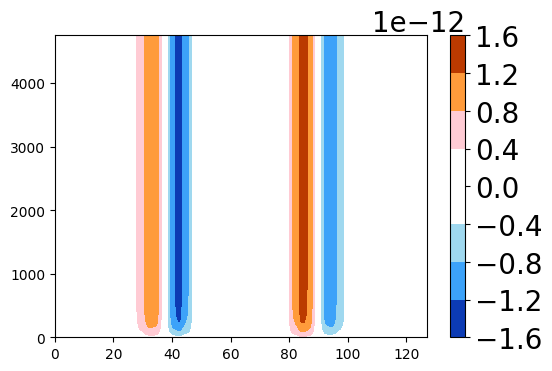

In [72]:
py.contourf(temp['vrt_forcing'][...,100], cmap=cmap); colorbar(20)

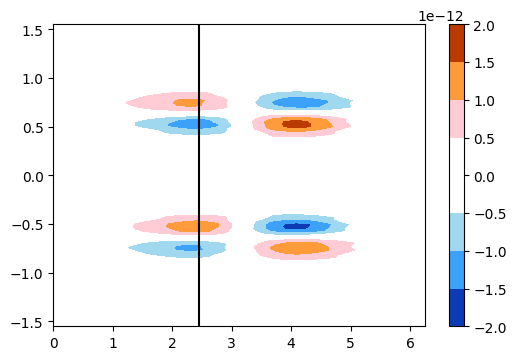

In [81]:
py.contourf(temp['lons'], temp['lats'], (temp['vrt_forcing'][-1000,...]), cmap=cmap); py.colorbar()
py.axvline(temp['lons'][100])

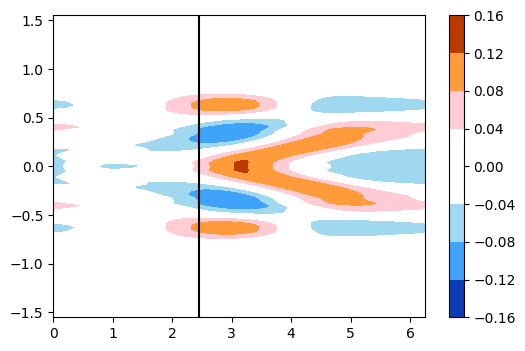

In [83]:
py.contourf(temp['lons'], temp['lats'], eddy(temp['U'][-1000,...]), cmap=cmap); py.colorbar()
py.axvline(temp['lons'][100])

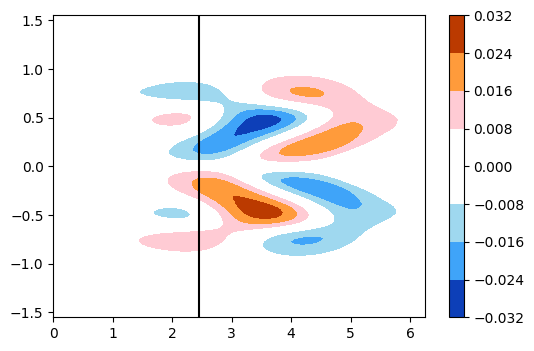

In [84]:
py.contourf(temp['lons'], temp['lats'], eddy(temp['V'][-1000,...]), cmap=cmap); py.colorbar()
py.axvline(temp['lons'][100])

In [74]:
ls /data/pbarpanda/spherical_SWE/evaluate_final_budget/momentum_forcing/Hmean_500_forcing_phase_speed_0_ms/vortcity_forcing_only_midlat_loc_40/_switch_on/H0_3000

equation_data.hdf5  input_file.hdf5  spatial_data.hdf5


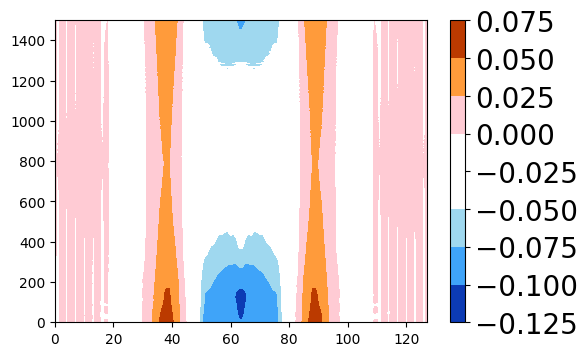

In [79]:
py.contourf(eddy(temp['U'])[1500:3000,...,100], cmap=cmap); colorbar(20)

In [ ]:
for extra in ['vortcity_forcing_midlat_loc_40_transient_Umax'] :#'alpha_5_switch_on_45_day', 'alpha_20_switch_on_80_day']:U_up_days_170 'U_up_days_237_mu_32_sigma_10', 'U_up_days_237_mu_55_sigma_10'
    for Hmean in ([500]):
        for H0 in ([5500]) : #3500 #3000, 1000, 0]): #0, 500, 1000, 1500, 2000, 2500, 3000, 3500 #0, 1000, 'alpha_20_switch_on_80_day'

                ps = 5;

                source  = '/data/pbarpanda/spherical_SWE/evaluate_final_budget/momentum_forcing/Hmean_%d_forcing_phase_speed_%d_ms/%s/H0_%d/'%(Hmean, ps, extra, H0)

                dicti_str = 'H0_%d_Hmean_%d_%s'%( H0, Hmean, extra)
                dir_name  = './Figures_different_fields_vrt_forcing_subplot/%s/eddy_phi'%(dicti_str)


In [64]:
ls /data/pbarpanda/spherical_SWE/evaluate_final_budget/momentum_forcing/Hmean_500_forcing_phase_speed_5_ms/vortcity_forcing_midlat_loc_40_transient_Umax/H0_5500

input_file.hdf5  spatial_data.hdf5


In [102]:
import glob
source0  = '/data/pbarpanda/spherical_SWE/evaluate_final_budget/momentum_forcing_Aug_2022/*'
sources  = glob.glob(source0)
for source in sources:
    ps      = 0 #int(source.split('_')[-2]) ### Here the phase speed of the vorticity forcing is set to 0
    source = glob.glob(source+'/*')[0]
    print (source)

/data/pbarpanda/spherical_SWE/evaluate_final_budget/momentum_forcing_Aug_2022/vortcity_forcing_midlat_loc_40_transient_Umax/H0_5500


In [101]:
sources

['/data/pbarpanda/spherical_SWE/evaluate_final_budget/momentum_forcing_Aug_2022/vortcity_forcing_midlat_loc_40_transient_Umax']